 # Project - Data Analysis

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

### Data acquisition

In [2]:
data = pd.read_csv("data/responses.csv")

Quick look at how the data is composed.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Columns: 150 entries, Music to House - block of flats
dtypes: float64(134), int64(5), object(11)
memory usage: 1.2+ MB


## Target variable

<b>Smoking</b> is the target variable. Let's see which values are contained in it.

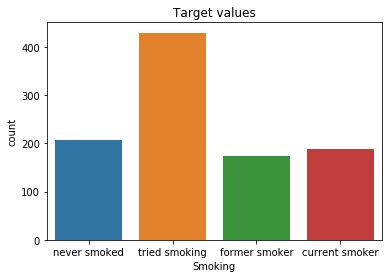

In [4]:
ax = sns.countplot(data=data, x='Smoking')
ax.set_title('Target values');

The goal of this project is to determine if a person has been a smoker during a prolonged period of his life. <br>
<p>For this reason we group together: <br>
    <ul>
        <li>the values <i>'never smoked'</i> and <i>'tried smoking'</i> under the label 'No' (0)</li>
        <li>the values <i>'former smoker'</i> and <i>'current smoker'</i> under the label 'Yes' (1)</li>
    </ul>
</p>
We call this new target variable <b>Smoker</b>.

In [5]:
data["Smoker"] = data["Smoking"].map({
    "never smoked": "No", 
    "tried smoking": "No", 
    "former smoker": "Yes", 
    "current smoker": "Yes"})
data.drop("Smoking", axis=1, inplace=True)

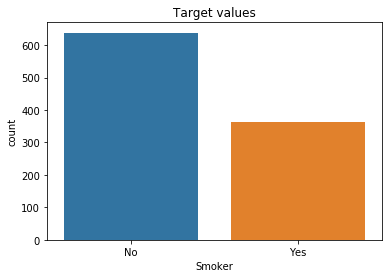

In [6]:
ax = sns.countplot(data=data, x='Smoker')
ax.set_title('Target values');

### Missing values

How many missing values does the target variable have?

In [7]:
print("Number of missing values in target variable: %d" % data["Smoker"].isnull().sum())

Number of missing values in target variable: 8


In the rows with a missing value for the target variable <i>'Smoker'</i>, which other values are missing?

Row 130 - Missing:  Documentary - Alcohol - Smoker - 
Row 149 - Missing:  Smoker - 
Row 525 - Missing:  Fun with friends - Friends versus money - Hypochondria - Smoker - 
Row 567 - Missing:  Documentary - Biology - Giving - Charity - Spending on looks - Smoker - 
Row 629 - Missing:  Alcohol - Healthy eating - Smoker - 
Row 708 - Missing:  Alcohol - Healthy eating - Smoker - 
Row 763 - Missing:  Geography - Smoker - 
Row 980 - Missing:  Passive sport - Smoker - 


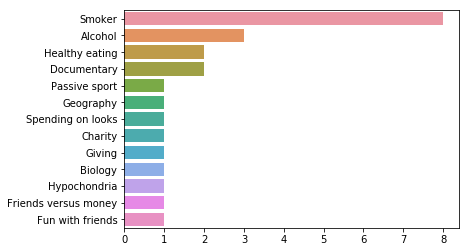

In [8]:
values_missing = dict()
for index, row in data[data["Smoker"].isnull()].iterrows():
    print("Row %d - Missing: "% index, end=" ")
    for col in row[row.isnull()].index:
        print(col, end=" - ")
        if col in values_missing:
            values_missing[col] += 1
        else:
            values_missing[col] = 1
    print()

s = pd.Series(values_missing).sort_values(ascending=False)
ax = sns.barplot(x=s, y=s.index)

Interesting to notice:
- Three people that chose to not indicate their smoking habits also avoided talking about alcohol consumption.
- Two of them also avoided talking about health habits.

We remove the rows with missing values for the target variable.

In [9]:
data = data.drop(data[data["Smoker"].isnull()].index)
print("Number of missing values in target: %d" % data["Smoker"].isnull().sum())

Number of missing values in target: 0


## Data visualization
We now procede to visualize some of the characteristics of this dataset in order to try to obtain a better understanding of it.

### Alcohol and Gender
Let's look at two features that will be interesting later, <i>'Alcohol'</i> and <i>'Gender'</i>. <br>
Are they related to each other and to the target variable <i>'Smoker'</i>?

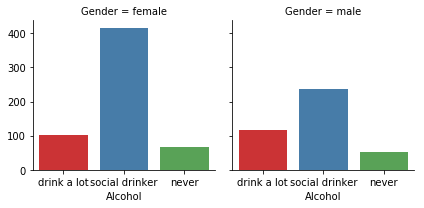

In [10]:
g = sns.FacetGrid(data, col="Gender")
g.map(sns.countplot, "Alcohol", palette='Set1', order=['drink a lot', 'social drinker', 'never']);

Males are more oriented towards heavy drinking than women.

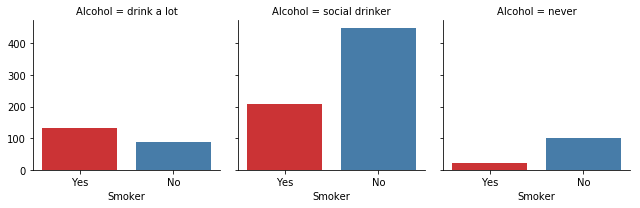

In [11]:
g = sns.FacetGrid(data, col="Alcohol")
g.map(sns.countplot, "Smoker", palette='Set1', order=['Yes', 'No']);

We can notice that it seems to be a linear correlation between the consumption of alcohol and smoking.

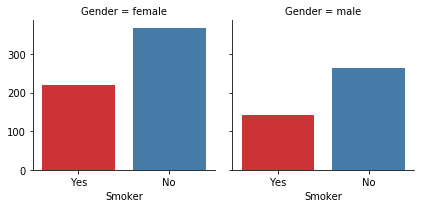

In [12]:
g = sns.FacetGrid(data, col="Gender")
g.map(sns.countplot, "Smoker", palette='Set1', order=['Yes', 'No']);

The proportion between smokers and non smokers does not change depending on the gender. <br>
More on this later.

### Age

And what about <i>'Age'</i>? Is it related to <i>'Smoker'</i>?

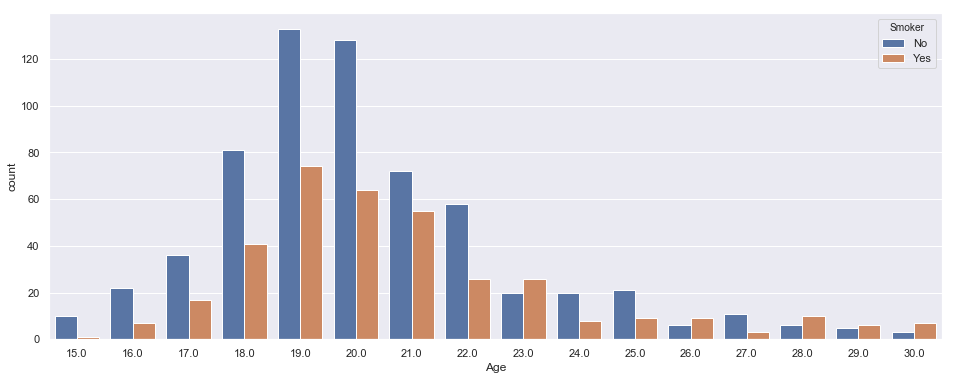

In [13]:
sns.set(rc={'figure.figsize':(16,6)})
sns.countplot(data=data, x="Age", hue="Smoker");

### Correlation
What are the features most heavily correlated?

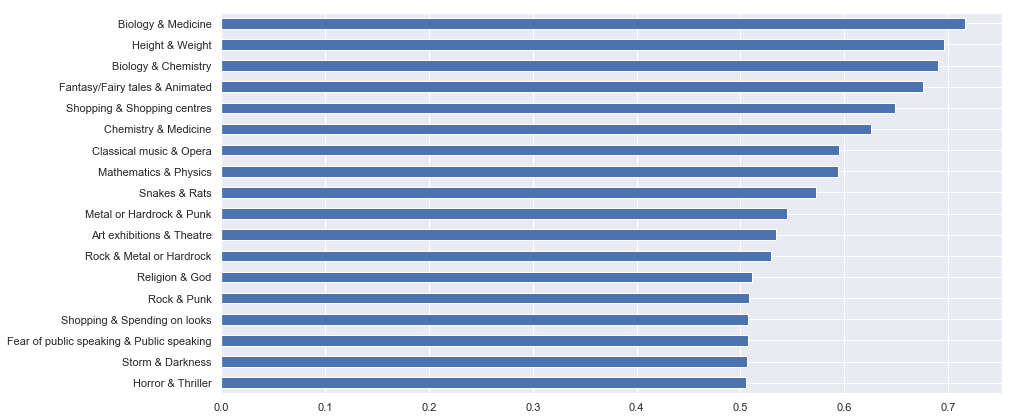

In [14]:
corr = data.corr()
ord_corr = dict()

# Saving heavily correlated features in a dictionary.
for row in range(corr.shape[0]):
    for col in range(corr.iloc[row].shape[0]):
        if abs(corr.iloc[row][col]) > 0.5 and row < col:
            key = corr.index[row] + " & " + corr.index[col]
            ord_corr[key] = corr.iloc[row][col]

# Plotting
pd.Series(ord_corr).sort_values().plot(kind='barh', figsize=(14,7));

## Data transformation

### Encoding of categorical variables
We have to transform the categorical variables into numerical ones.

In [15]:
data.describe(exclude=np.number)

,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats,Smoker
count,1000,1000,1000,1002,996,999,1001,1000,998,998,1002
unique,3,3,4,4,2,2,6,2,2,2,2
top,social drinker,i am always on time,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats,No
freq,658,396,544,737,589,899,617,747,702,590,638


In [16]:
data["Alcohol"] = data["Alcohol"].map({"never": 0, "social drinker": 1, "drink a lot": 2})

data["Punctuality"] = data["Punctuality"].map({"i am often early": 0, "i am always on time": 1, "i am often running late": 2})

data["Lying"] = data["Lying"].map({"never": 0, "sometimes": 1, "only to avoid hurting someone": 2, "everytime it suits me": 3})

data["Internet usage"] = data["Internet usage"].map({
    "no time at all": 0, 
    "less than an hour a day": 1, 
    "few hours a day": 2, 
    "most of the day": 3})

data["Female"] = data["Gender"].map({"male": 0, "female": 1})
data.drop("Gender", axis=1, inplace=True)

data["Right handed"] = data["Left - right handed"].map({"left handed": 0, "right handed": 1})
data.drop("Left - right handed", axis=1, inplace=True)

data["Education"] = data["Education"].map({
    "currently a primary school pupil": 0,
    "primary school": 1, 
    "secondary school": 2, 
    "college/bachelor degree": 3, 
    "masters degree": 4,
    "doctorate degree": 5})

data["Only child"] = data["Only child"].map({"no": 0, "yes": 1})

data["Living in a city"] = data["Village - town"].map({"village": 0, "city": 1})
data.drop("Village - town", axis=1, inplace=True)

data["Living in a flat"] = data["House - block of flats"].map({"house/bungalow": 0, "block of flats": 1})
data.drop("House - block of flats", axis=1, inplace=True)

data["Smoker"] = data["Smoker"].map({"No": 0, "Yes": 1})

Now that we have all the features in a numerical form, we can see which features are more correlated with our target variable.

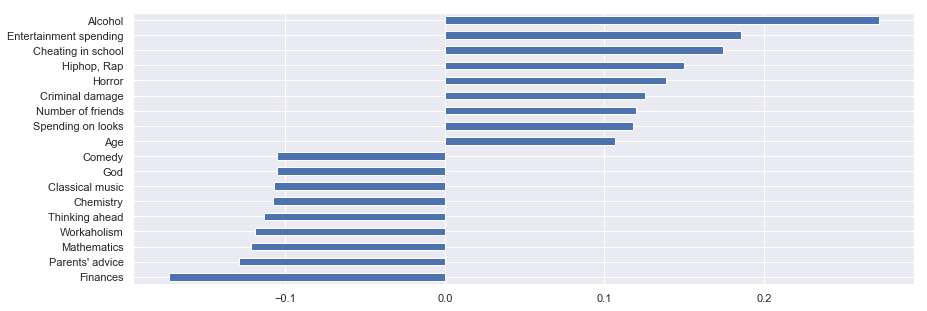

In [17]:
corr = data.corr()
corr_target = corr["Smoker"]
corr_target = corr_target.sort_values()
corr_target = corr_target.drop("Smoker")

# Selection of the most correlated features.
relevant_features = corr_target[abs(corr_target)>0.1]
relevant_features.plot(kind='barh', figsize=(14,5));

We can observe that 'Alcohol' has the highest correlation value (0.27), which is consistent with what we saw before, during the data visualization step.

#### An odd fact

While looking at these numbers, I noticed something strange. <br>
It is popular knowledge that men are usually more inclined to smoking than women, but this does not show at all in our dataset.

In [18]:
print("Correlation between 'Gender' and 'Smoker': %.3f" % (corr_target['Female']))

Correlation between 'Gender' and 'Smoker': 0.023


Actually, considering both positive and negative coefficients, <i>'Female'</i> is only the 120th highest correlated feature! 

In [19]:
abs_corr_target = corr_target.abs().sort_values(ascending=False)
abs_corr_target.index.get_loc("Female")

120

After some research, I found out that in Slovakia, the country where the survey that generated the dataset took place, [39.7%](https://tradingeconomics.com/slovakia/smoking-prevalence-males-percent-of-adults-wb-data.html) of the men were smokers during 2015, against only [17.6%](https://tradingeconomics.com/slovakia/smoking-prevalence-females-percent-of-adults-wb-data.html) of females. <br>
Is this ratio (2.25) respected in our dataset?

In [20]:
smokers_by_gender = data.groupby("Female").mean()["Smoker"]
print("In our dataset %.1f%% of men are smokers." % (smokers_by_gender[0]*100))
print("In our dataset %.1f%% of women are smokers." % (smokers_by_gender[1]*100))
print("RATIO: %f" % (smokers_by_gender[0]/smokers_by_gender[1]))

In our dataset 35.1% of men are smokers.
In our dataset 37.4% of women are smokers.
RATIO: 0.940663


It is utterly striking to notice that 37.3% of the women that took the survey affirmed to be smokers, a number that is actually higher than the men's one! <br>
This may be due to the limited size of the sample. <br>
It is a shame, because an higher correlation between this feature and the target one could have greatly helped improving the accuracy of our models.

### Missing values

Let's check how many missing values are present in the dataset.

In [21]:
data_na = round((data.isnull().sum() / len(data)) * 100, 3)
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing": data.isnull().sum(),  "%": data_na}).sort_values(by="%", ascending=False)[:30]
missing_data.head(10)

,Missing,%
Weight,20,1.996
Height,20,1.996
Passive sport,14,1.397
Chemistry,10,0.998
Punk,8,0.798
Theatre,8,0.798
Latino,8,0.798
Geography,8,0.798
Alternative,7,0.699
Age,7,0.699


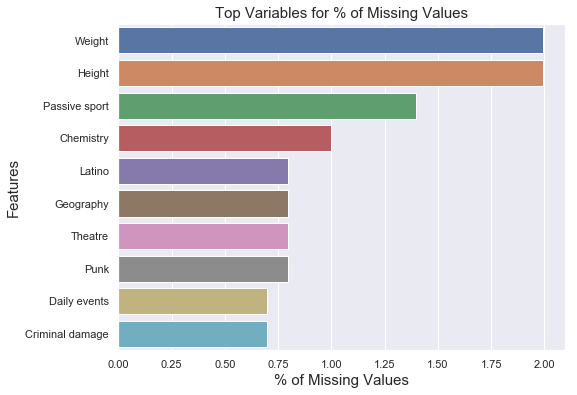

In [22]:
f, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=data_na[:10], y=data_na.index[:10])
plt.xlabel('% of Missing Values', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Top Variables for % of Missing Values', fontsize=15);

We search for features that have a high correlation with <i>'Weight'</i> and <i>'Height'</i>. What we find is not a surprise.

In [23]:
corr_weight = corr["Weight"].sort_values(ascending=False)
imp_corr_weight = corr_weight[corr_weight.abs() > 0.4]
imp_corr_weight

Weight    1.000000
Height    0.695696
Female   -0.644266
Name: Weight, dtype: float64

We try to impute the missing values for these features by using what we just discovered.

In [24]:
# Filling missing value of Weight with the median weight of similar rows according to Height and Female
index_NaN_weight = list(data["Weight"][data["Weight"].isnull()].index)

for i in index_NaN_weight:
    weight_med = data["Weight"].median()
    weight_pred = data["Weight"][((data['Height'] == data.iloc[i]["Height"]) & (data['Female'] == data.iloc[i]["Female"]))].median()
    if not np.isnan(weight_pred) :
        data['Weight'].iloc[i] = weight_pred
    else:
        data['Weight'].iloc[i] = weight_med

In [25]:
# Filling missing value of Height with the median weight of similar rows according to Weight and Female
index_NaN_height = list(data["Height"][data["Height"].isnull()].index)

for i in index_NaN_height:
    height_med = data["Height"].median()
    height_pred = data["Height"][((data['Weight'] == data.iloc[i]["Weight"]) & (data['Female'] == data.iloc[i]["Female"]))].median()
    if not np.isnan(height_pred) :
        data['Height'].iloc[i] = height_pred
    else:
        data['Height'].iloc[i] = height_med

We substitute the remaining missing values with the most frequent value in their column.

In [26]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data = pd.DataFrame(data=imp.fit_transform(data), columns=data.columns, index=data.index)

print("Missing values: %d" % (data.isnull().sum().sum()))

Missing values: 0


### Outliers detection

There are probably not going to be a lot of features prone to outliers, given that most of them have values ranging only from 1 to 5. <br>
Two of the most prone ones are, again, <i>'Weight'</i> and <i>'Height'</i>. <br>
Let's visualize them.

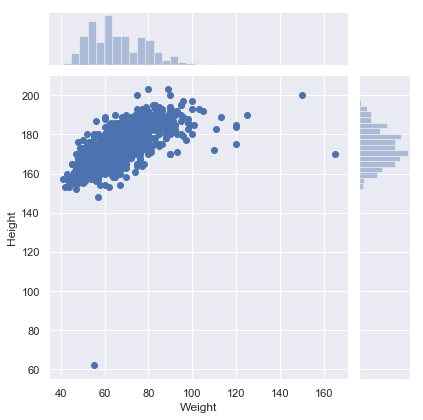

In [27]:
sns.jointplot(x='Weight', y='Height', data=data);

Let's have a closer look to the <i>'Weight'</i> outliers. We plot them with <i>'Age'</i>.

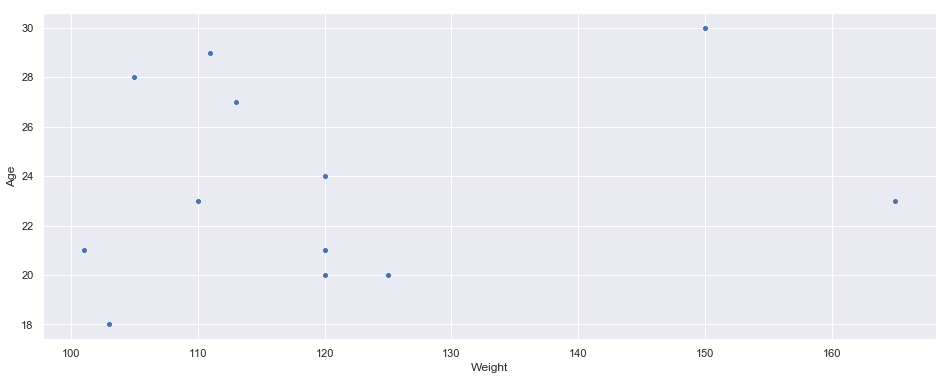

In [28]:
sns.scatterplot(x="Weight", y="Age", data=data[data["Weight"] > 100]);

There is not much that we can say about these outliers. They are feasible values, so we leave them be.

But what about that lonely <i>'Height'</i> value?

In [29]:
data.loc[data["Height"] < 100, ['Female', 'Age', 'Height', 'Weight', 'Smoker']]

,Female,Age,Height,Weight,Smoker
676,1.0,20.0,62.0,55.0,1.0


The <i>'Height'</i> outlier is certainly a mistake made compiling the survey, probably it was meant to be 162. So we fix it.

In [30]:
data.loc[676, 'Height'] = 162

### Binning of continuous variables

Binning refers to dividing a list of continuous variables into groups. <br>
We bin values of <i>'Age'</i>, <i>'Weight'</i> and <i>'Height'</i> in order to improve the accuracy of the models.

In [31]:
# Continuous variable bins, we found that 5, 6, 6 are the optimal numbers in this case.
data['AgeBin'] = pd.cut(data['Age'], 5)
data['HeightBin'] = pd.qcut(data['Height'].astype(int), 6)
data['WeightBin'] = pd.qcut(data['Weight'].astype(int), 6)

# Convert objects to categories.
data['Age'] = LabelEncoder().fit_transform(data['AgeBin'])
data['Height'] = LabelEncoder().fit_transform(data['HeightBin'])
data['Weight'] = LabelEncoder().fit_transform(data['WeightBin'])

# Drop unnecessary features.
drop_features = ['AgeBin', 'HeightBin', 'WeightBin']
data = data.drop(drop_features, axis=1)

Now we save the cleaned data into a file, ready to be used for modeling.

In [32]:
data.to_csv("data/clean_data.csv", index=False)